# Heston Model Calibration & Surface Generation

This notebook:
1. Loads Heston inputs (from Phase 3)
2. Calibrates Heston model for each trading date using QuantLib
3. Generates IV surfaces on the same 374-point grid as VAE
4. Saves calibrated surfaces for comparison

In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import warnings

# Add src to path
sys.path.insert(0, str(Path("../..").resolve()))

# -------------------
# CONFIG
# -------------------
TICKER = "AAPL"
PROCESSED_DIR = Path("../../data/processed")
HESTON_DIR = PROCESSED_DIR / "heston"

INPUT_PATH = HESTON_DIR / "inputs" / f"{TICKER}_heston_inputs.parquet"
OUTPUT_DIR = HESTON_DIR / "surfaces"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Input: {INPUT_PATH}")
print(f"Exists: {INPUT_PATH.exists()}")

Input: ..\..\data\processed\heston\inputs\AAPL_heston_inputs.parquet
Exists: True


In [2]:
# Import calibration and pricing modules
from src.models.heston import (
    HestonParams,
    calibrate_heston,
    CalibrationResult,
    heston_iv,
)
from src.data.volsurface_grid import GridSpec

print("Imports successful!")

Imports successful!


## 1. Load Calibration Inputs

In [3]:
df = pd.read_parquet(INPUT_PATH)
print(f"Loaded {len(df):,} calibration points")
print(f"Unique dates: {df['date'].nunique():,}")
print(f"Columns: {df.columns.tolist()}")
df.head()

Loaded 171,847 calibration points
Unique dates: 1,290
Columns: ['date', 'days', 'T', 'delta', 'cp_flag', 'S0', 'K', 'r', 'q', 'iv_market', 'moneyness']


,date,days,T,delta,cp_flag,S0,K,r,q,iv_market,moneyness
0,2016-01-15,152,0.416438,0.10,C,97.13,151.306835,0.629217,0.2,0.307552,1.557777
1,2016-01-15,152,0.416438,0.15,C,97.13,143.316045,0.629217,0.2,0.301833,1.475508
2,2016-01-15,152,0.416438,0.20,C,97.13,137.690308,0.629217,0.2,0.300407,1.417588
3,2016-01-15,152,0.416438,0.25,C,97.13,133.258292,0.629217,0.2,0.302165,1.371958
4,2016-01-15,152,0.416438,0.30,C,97.13,129.422327,0.629217,0.2,0.305443,1.332465


In [4]:
# Get unique dates
all_dates = sorted(df["date"].unique())
print(f"Date range: {all_dates[0]} to {all_dates[-1]}")
print(f"Total dates in dataset: {len(all_dates)}")

Date range: 2016-01-15 00:00:00 to 2025-08-29 00:00:00
Total dates in dataset: 1290


In [5]:
# Load test dates from VAE evaluation (for fair comparison)
# Only calibrate Heston on the same dates VAE was tested on
TEST_DATES_PATH = Path("../../artifacts/eval/surfaces/vae_surface_dates.csv")

if TEST_DATES_PATH.exists():
    test_dates_df = pd.read_csv(TEST_DATES_PATH)
    test_dates_df["date"] = pd.to_datetime(test_dates_df["date"])
    test_dates_set = set(test_dates_df["date"].dt.date)
    
    # Filter to only dates that exist in both
    dates = [d for d in all_dates if pd.Timestamp(d).date() in test_dates_set]
    print(f"Using TEST DATES ONLY for fair comparison")
    print(f"  Test dates from VAE: {len(test_dates_set)}")
    print(f"  Dates available in Heston inputs: {len(all_dates)}")
    print(f"  Dates to calibrate: {len(dates)}")
else:
    print(f"WARNING: Test dates file not found at {TEST_DATES_PATH}")
    print(f"Run eval_vae.ipynb first to generate test dates.")
    print(f"Falling back to ALL dates (not recommended for comparison)")
    dates = all_dates

Using TEST DATES ONLY for fair comparison
  Test dates from VAE: 244
  Dates available in Heston inputs: 1290
  Dates to calibrate: 244


## 2. Define Output Grid

Load the same grid used by VAE to ensure surfaces are comparable.

In [6]:
# Load VAE grid specification to ensure identical grids
import json

GRID_SPEC_PATH = Path("../../artifacts/eval/surfaces/grid_spec.json")

if GRID_SPEC_PATH.exists():
    with open(GRID_SPEC_PATH) as f:
        vae_grid = json.load(f)
    
    GRID_SPEC = GridSpec(
        days_grid=np.array(vae_grid["days_grid"]),
        delta_grid=np.array(vae_grid["delta_grid"]),
        cp_order=tuple(vae_grid["cp_order"]),
    )
    print("Loaded grid from VAE output (ensures identical grids)")
else:
    # Fallback to default grid if VAE hasn't been run
    print("WARNING: VAE grid_spec.json not found, using default grid")
    GRID_SPEC = GridSpec(
        days_grid=np.array([10, 30, 60, 91, 122, 152, 182, 273, 365, 547, 730]),
        delta_grid=np.arange(0.10, 0.91, 0.05).round(2),
        cp_order=("C", "P"),
    )

print(f"Days grid: {GRID_SPEC.days_grid}")
print(f"Delta grid: {GRID_SPEC.delta_grid}")
print(f"Expected surface size: {len(GRID_SPEC.cp_order)} × {len(GRID_SPEC.days_grid)} × {len(GRID_SPEC.delta_grid)} = {len(GRID_SPEC.cp_order) * len(GRID_SPEC.days_grid) * len(GRID_SPEC.delta_grid)}")

Loaded grid from VAE output (ensures identical grids)
Days grid: [ 10.  30.  60.  91. 122. 152. 182. 273. 365. 547. 730.]
Delta grid: [0.1        0.15000001 0.2        0.25       0.30000001 0.34999999
 0.40000001 0.44999999 0.5        0.55000001 0.60000002 0.64999998
 0.69999999 0.75       0.80000001 0.85000002 0.89999998]
Expected surface size: 2 × 11 × 17 = 374


## 3. Calibrate Heston for Each Date

Uses QuantLib's `HestonModelHelper` + `LevenbergMarquardt` optimizer.

In [7]:
def calibrate_single_date(date_df: pd.DataFrame) -> tuple[CalibrationResult, dict]:
    """
    Calibrate Heston for a single date.
    
    Returns (CalibrationResult, market_data_dict)
    """
    S0 = date_df["S0"].iloc[0]
    r = date_df["r"].mean()  # Average rate across maturities
    q = date_df["q"].mean()  # Average carry rate
    
    result = calibrate_heston(
        S0=S0,
        r=r,
        q=q,
        maturities=date_df["T"].values,
        strikes=date_df["K"].values,
        market_ivs=date_df["iv_market"].values,
        cp_flags=date_df["cp_flag"].values,
        max_iterations=500,
    )
    
    market_data = {"S0": S0, "r": r, "q": q}
    return result, market_data

In [8]:
# Test on first date
test_date = dates[0]
test_df = df[df["date"] == test_date]

print(f"Testing calibration on {test_date}...")
print(f"  Points: {len(test_df)}")

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    result, mkt = calibrate_single_date(test_df)

print(f"\nCalibration result:")
print(result)
print(f"\nFeller condition: {result.params.feller_condition}")

Testing calibration on 2024-09-10 00:00:00...
  Points: 175

Calibration result:
CalibrationResult(SUCCESS, error=0.106922)
  v0=0.103637, kappa=2.1646, theta=0.043009, sigma=0.1201, rho=0.0159

Feller condition: True


In [9]:
# Calibrate all dates (with progress bar)
# Calibrates only TEST dates for fair comparison with VAE

calibration_results = []
market_data_by_date = {}

print(f"Calibrating {len(dates)} dates...")

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    for date in tqdm(dates, desc="Calibrating"):
        date_df = df[df["date"] == date]
        
        try:
            result, mkt = calibrate_single_date(date_df)
            calibration_results.append({
                "date": date,
                "v0": result.params.v0,
                "kappa": result.params.kappa,
                "theta": result.params.theta,
                "sigma": result.params.sigma,
                "rho": result.params.rho,
                "error": result.error,
                "success": result.success,
                "feller": result.params.feller_condition,
            })
            market_data_by_date[date] = mkt
        except Exception as e:
            calibration_results.append({
                "date": date,
                "v0": np.nan, "kappa": np.nan, "theta": np.nan,
                "sigma": np.nan, "rho": np.nan,
                "error": np.inf,
                "success": False,
                "feller": False,
            })

calib_df = pd.DataFrame(calibration_results)
print(f"\nCalibration complete!")
print(f"Success rate: {calib_df['success'].mean()*100:.1f}%")
print(f"Feller satisfied: {calib_df['feller'].mean()*100:.1f}%")

Calibrating 244 dates...


Calibrating:   0%|          | 0/244 [00:00<?, ?it/s]


Calibration complete!
Success rate: 100.0%
Feller satisfied: 68.9%


In [10]:
# Save calibration parameters
calib_path = OUTPUT_DIR / f"{TICKER}_heston_params.csv"
calib_df.to_csv(calib_path, index=False)
print(f"Saved calibration params: {calib_path}")

# Summary stats
print("\nParameter summary (successful calibrations):")
print(calib_df[calib_df["success"]][["v0", "kappa", "theta", "sigma", "rho"]].describe())

Saved calibration params: ..\..\data\processed\heston\surfaces\AAPL_heston_params.csv

Parameter summary (successful calibrations):
               v0       kappa       theta       sigma         rho
count  244.000000  244.000000  244.000000  244.000000  244.000000
mean     0.142007    4.212094    0.028628    0.300629   -0.152570
std      0.555311   27.265964    0.024167    1.210979    0.261965
min      0.033716    1.343353    0.000034    0.004694   -1.000000
25%      0.069461    1.713192    0.009929    0.175306   -0.232169
50%      0.092366    1.867436    0.022998    0.207130   -0.162544
75%      0.122057    2.338011    0.040330    0.227663   -0.034710
max      8.705414  427.636906    0.104613   19.058312    0.566007


## 4. Generate Heston IV Surfaces

In [11]:
from src.models.heston.bs import strike_from_delta

def generate_heston_surface(
    params: HestonParams,
    S0: float,
    r: float,
    q: float,
    grid_spec: GridSpec,
) -> np.ndarray:
    """
    Generate Heston IV surface on the standard grid.
    
    Returns:
        np.ndarray of shape (C, H, W) = (2, 11, 17)
    """
    n_cp = len(grid_spec.cp_order)
    n_days = len(grid_spec.days_grid)
    n_delta = len(grid_spec.delta_grid)
    
    surface = np.full((n_cp, n_days, n_delta), np.nan)
    
    for i_cp, cp in enumerate(grid_spec.cp_order):
        for i_d, days in enumerate(grid_spec.days_grid):
            T = days / 365.0
            
            for i_delta, delta in enumerate(grid_spec.delta_grid):
                # We need ATM IV to convert delta→strike
                # Use v0^0.5 as proxy for ATM IV
                sigma_atm = np.sqrt(params.v0)
                
                # Convert delta to strike (cp should be "C" or "P")
                K = strike_from_delta(
                    S=S0,
                    T=T,
                    r=r,
                    q=q,
                    sigma=sigma_atm,
                    delta=delta,
                    cp_flag=cp,  # "C" or "P"
                )
                
                if K is None or np.isnan(K) or K <= 0:
                    continue
                
                # Compute Heston IV at this strike
                try:
                    iv = heston_iv(
                        S0, K, T, r, q, params,
                        cp,  # "C" or "P"
                    )
                    if iv is not None and iv > 0 and iv < 2.0:  # Reasonable IV
                        surface[i_cp, i_d, i_delta] = iv
                except:
                    pass
    
    return surface

In [12]:
# Test surface generation
test_params = HestonParams(
    v0=calib_df.iloc[0]["v0"],
    kappa=calib_df.iloc[0]["kappa"],
    theta=calib_df.iloc[0]["theta"],
    sigma=calib_df.iloc[0]["sigma"],
    rho=calib_df.iloc[0]["rho"],
)
test_mkt = market_data_by_date[dates[0]]

print("Generating test surface...")
test_surface = generate_heston_surface(test_params, test_mkt["S0"], test_mkt["r"], test_mkt["q"], GRID_SPEC)
print(f"Surface shape: {test_surface.shape}")
print(f"Non-NaN values: {np.sum(~np.isnan(test_surface))} / {test_surface.size}")
print(f"IV range: [{np.nanmin(test_surface)*100:.1f}%, {np.nanmax(test_surface)*100:.1f}%]")

Generating test surface...
Surface shape: (2, 11, 17)
Non-NaN values: 350 / 374
IV range: [23.8%, 31.9%]


In [13]:
# Generate surfaces for all dates
surfaces = []
surface_dates = []

print(f"Generating surfaces for {len(dates)} dates...")

for idx, row in tqdm(calib_df.iterrows(), total=len(calib_df), desc="Generating surfaces"):
    date = row["date"]
    
    if not row["success"] or np.isnan(row["v0"]):
        # Skip failed calibrations
        continue
    
    params = HestonParams(
        v0=row["v0"],
        kappa=row["kappa"],
        theta=row["theta"],
        sigma=row["sigma"],
        rho=row["rho"],
    )
    
    mkt = market_data_by_date.get(date, {})
    if not mkt:
        continue
    
    try:
        surface = generate_heston_surface(params, mkt["S0"], mkt["r"], mkt["q"], GRID_SPEC)
        
        # Check if surface is valid (at least 50% non-NaN)
        if np.sum(~np.isnan(surface)) >= surface.size * 0.5:
            surfaces.append(surface)
            surface_dates.append(date)
    except Exception as e:
        pass

print(f"\nGenerated {len(surfaces)} valid surfaces")

Generating surfaces for 244 dates...


Generating surfaces:   0%|          | 0/244 [00:00<?, ?it/s]


Generated 244 valid surfaces


In [14]:
# Stack into tensor
heston_surfaces = np.stack(surfaces, axis=0)  # (N, C, H, W)
print(f"Heston surfaces tensor: {heston_surfaces.shape}")
print(f"  Memory: {heston_surfaces.nbytes / 1e6:.1f} MB")

Heston surfaces tensor: (244, 2, 11, 17)
  Memory: 0.7 MB


## 5. Save Heston Surfaces

In [15]:
# Save as numpy array
surfaces_path = OUTPUT_DIR / f"{TICKER}_heston_surfaces.npy"
np.save(surfaces_path, heston_surfaces)
print(f"Saved surfaces: {surfaces_path}")

# Save dates mapping
dates_df = pd.DataFrame({"date": surface_dates})
dates_path = OUTPUT_DIR / f"{TICKER}_heston_surface_dates.csv"
dates_df.to_csv(dates_path, index=False)
print(f"Saved dates: {dates_path}")

Saved surfaces: ..\..\data\processed\heston\surfaces\AAPL_heston_surfaces.npy
Saved dates: ..\..\data\processed\heston\surfaces\AAPL_heston_surface_dates.csv


In [16]:
# Also save as parquet for easier pandas use
# Flatten surfaces to 2D: (N, 374)
n_surfaces = heston_surfaces.shape[0]
flat_surfaces = heston_surfaces.reshape(n_surfaces, -1)

# Create column names
col_names = []
for cp in GRID_SPEC.cp_order:
    for days in GRID_SPEC.days_grid:
        for delta in GRID_SPEC.delta_grid:
            col_names.append(f"{cp}_{days}d_{delta:.2f}d")

# Build DataFrame
surfaces_df = pd.DataFrame(flat_surfaces, columns=col_names)
surfaces_df.insert(0, "date", surface_dates)

parquet_path = OUTPUT_DIR / f"{TICKER}_heston_surfaces.parquet"
surfaces_df.to_parquet(parquet_path, index=False)
print(f"Saved parquet: {parquet_path}")
print(f"Shape: {surfaces_df.shape}")

Saved parquet: ..\..\data\processed\heston\surfaces\AAPL_heston_surfaces.parquet
Shape: (244, 375)


## 6. Validation Plots

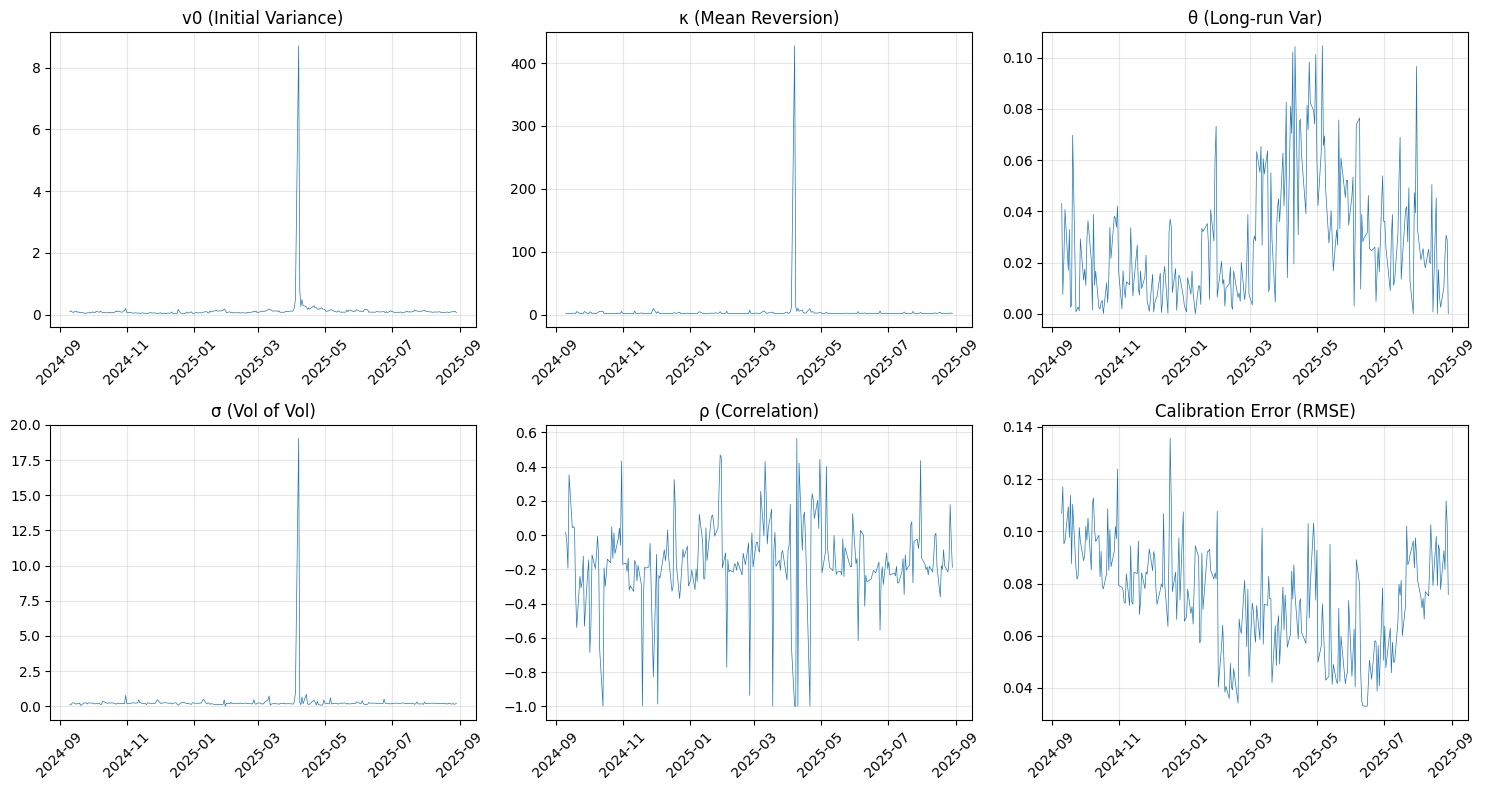

In [17]:
import matplotlib.pyplot as plt

# Plot parameter time series
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

params_to_plot = ["v0", "kappa", "theta", "sigma", "rho", "error"]
titles = ["v0 (Initial Variance)", "κ (Mean Reversion)", "θ (Long-run Var)", 
          "σ (Vol of Vol)", "ρ (Correlation)", "Calibration Error (RMSE)"]

successful = calib_df[calib_df["success"]]

for ax, param, title in zip(axes, params_to_plot, titles):
    ax.plot(successful["date"], successful[param], linewidth=0.5)
    ax.set_title(title)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / f"{TICKER}_heston_params_timeseries.png", dpi=150)
plt.show()

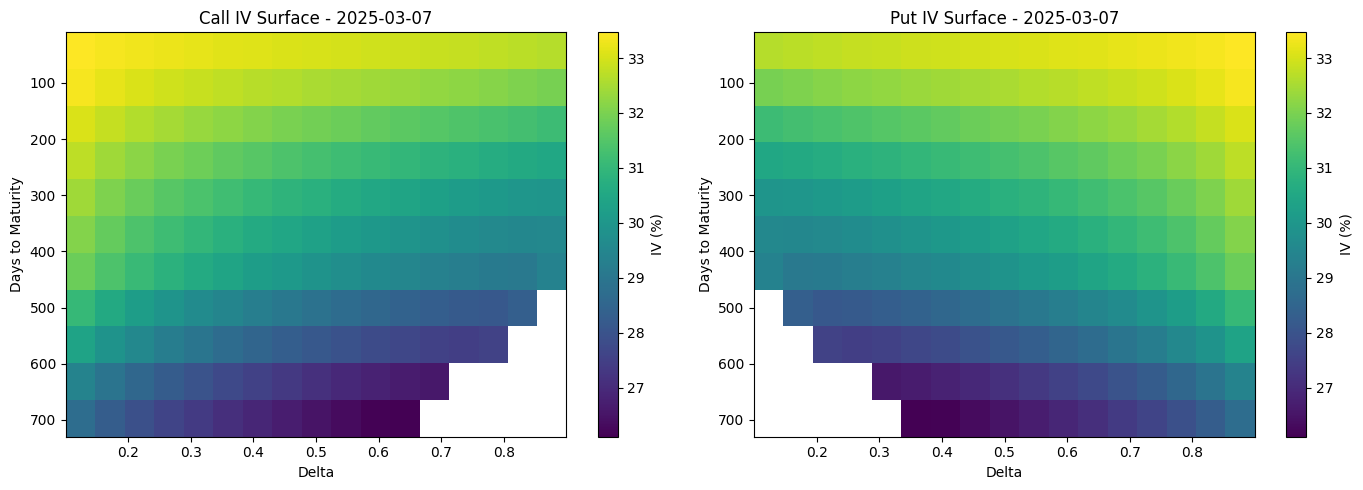

In [18]:
# Plot sample surface
sample_idx = len(surfaces) // 2
sample_surface = surfaces[sample_idx]
sample_date = surface_dates[sample_idx]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for i, (ax, cp) in enumerate(zip(axes, ["Call", "Put"])):
    im = ax.imshow(sample_surface[i] * 100, aspect='auto', cmap='viridis',
                   extent=[GRID_SPEC.delta_grid[0], GRID_SPEC.delta_grid[-1], 
                           GRID_SPEC.days_grid[-1], GRID_SPEC.days_grid[0]])
    ax.set_xlabel("Delta")
    ax.set_ylabel("Days to Maturity")
    ax.set_title(f"{cp} IV Surface - {str(sample_date)[:10]}")
    plt.colorbar(im, ax=ax, label="IV (%)")

plt.tight_layout()
plt.savefig(OUTPUT_DIR / f"{TICKER}_sample_heston_surface.png", dpi=150)
plt.show()

In [19]:
print("="*60)
print("PHASE 6 COMPLETE: Heston Surfaces Generated")
print("="*60)
print(f"\nOutputs:")
print(f"  • {calib_path.name} - Calibrated parameters")
print(f"  • {surfaces_path.name} - Surfaces as numpy array")
print(f"  • {parquet_path.name} - Surfaces as parquet")
print(f"\nSummary:")
print(f"  • {len(surfaces)} surfaces generated")
print(f"  • Shape: {heston_surfaces.shape} = (dates, channels, maturities, deltas)")
print(f"  • Calibration success rate: {calib_df['success'].mean()*100:.1f}%")

PHASE 6 COMPLETE: Heston Surfaces Generated

Outputs:
  • AAPL_heston_params.csv - Calibrated parameters
  • AAPL_heston_surfaces.npy - Surfaces as numpy array
  • AAPL_heston_surfaces.parquet - Surfaces as parquet

Summary:
  • 244 surfaces generated
  • Shape: (244, 2, 11, 17) = (dates, channels, maturities, deltas)
  • Calibration success rate: 100.0%
